In [79]:
import numpy as np

######## DO NOT MODIFY THIS FUNCTION ########
def draw_rand_label(x, label_list):
    seed = abs(np.sum(x))
    while seed < 1:
        seed = 10 * seed
    seed = int(1000000 * seed)
    np.random.seed(seed)
    return np.random.choice(label_list)
#############################################

In [80]:
banknote = np.genfromtxt("data_banknote_authentication.txt", delimiter=",")

In [81]:
class Q1:
    def feature_means(self, banknote):
        avgs = []
        for i in range(banknote.shape[-1]-1):
            avgs.append(np.average(banknote[:, i]))
        return avgs

    def covariance_matrix(self, banknote):
        return np.cov(banknote[:,:4], rowvar=False)

    def feature_means_class_1(self, banknote):
        return self.feature_means(banknote[banknote[:,4] == 1])

    def covariance_matrix_class_1(self, banknote):
        return self.covariance_matrix(banknote[banknote[:,4] == 1])

In [82]:
class HardParzen:
    def __init__(self, h):
        self.h = h

    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        self.label_list = np.unique(train_labels)
    
    def compute_predictions(self, test_data):
        num_test = test_data.shape[0]
        counts = np.ones((num_test, len(self.label_list)))
        classes_pred = np.zeros(num_test)

        for i, observation in enumerate(test_data):
            # Get distance from point ex and every training example.
            distances = np.sqrt(np.sum((self.train_inputs - observation) ** 2, axis=1))
        
            # Get an array of all the points that are within the parzen window of the example point.
            neighbour_indices = []
            parzen_radius = self.h
            neighbour_indices = np.array([j for j in range(len(distances)) if distances[j] <= parzen_radius])
            
            # If there are no points in the window, draw randomly, otherwise perform a vote.
            if neighbour_indices.size == 0:
                classes_pred[i] = draw_rand_label(observation, self.train_labels)
            else: 
                for k in neighbour_indices:
                    counts[i, int(self.train_labels[k])] += 1
                classes_pred[i] = np.argmax(counts[i, :])
            
        return classes_pred

In [83]:
class SoftRBFParzen:
    def __init__(self, sigma):
        self.sigma = sigma

    def train(self, train_inputs, train_labels):
        self.train_inputs = train_inputs
        self.train_labels = train_labels
        self.label_list = np.unique(train_labels)

    def compute_predictions(self, test_data):
        num_test = test_data.shape[0]
        classes_pred = np.zeros(num_test)
        
        for i, observation in enumerate(test_data):
            # Get distance from point ex and every training example.
            euclidean_distances = np.sqrt(np.sum((self.train_inputs - observation) ** 2, axis=1))
            
            # get sum of k
            ksum = 0
            kysum = np.ones(len(self.label_list))
            int_sum = np.zeros((test_data.shape[0], len(self.label_list)))
            
            for j, dist in enumerate(euclidean_distances):
                k = (1/(((2*np.pi)**len(self.label_list))*(self.sigma**(2*len(self.label_list)))))*np.exp(-0.5*((dist**2)/(self.sigma**2)))
                ksum += k
                kysum[int(self.train_labels[j])] += k
            
            # get intermediate sum
            int_sum = (1/ksum)*(kysum)
            
            classes_pred[i] = np.argmax(int_sum)
            
        return classes_pred

In [84]:
def split_dataset(banknote):
    train = banknote[[i for i in range(banknote.shape[0]) if i % 5 <= 2]]
    validation = banknote[[i for i in range(banknote.shape[0]) if i % 5 == 3]]
    test = banknote[[i for i in range(banknote.shape[0]) if i % 5 == 4]]
    return (train, validation, test)

In [85]:
class ErrorRate:
    def __init__(self, x_train, y_train, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def hard_parzen(self, h):
        HP = HardParzen(h)
        HP.train(train_inputs=self.x_train, train_labels=self.y_train)
        preds = HP.compute_predictions(test_data=self.x_val)
        return preds[preds != self.y_val].shape[0]/preds.shape[0]

    def soft_parzen(self, sigma):
        SP = SoftRBFParzen(sigma)
        SP.train(train_inputs=self.x_train, train_labels=self.y_train)
        preds = SP.compute_predictions(test_data=self.x_val)
        return preds[preds != self.y_val].shape[0]/preds.shape[0]

In [87]:
import matplotlib.pyplot as plt

/Users/Matteo/miniconda/envs/mila3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Matteo/miniconda/envs/mila3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars


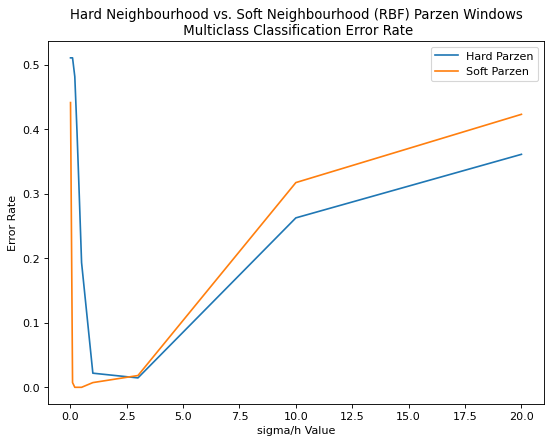

In [31]:
params = [0.01,0.1,0.2,0.3,0.4,0.5,1.0,3.0,10.0,20.0]
y1 = []
y2 = []
for p in params:
    y1.append(ER.hard_parzen(h=p))
    y2.append(ER.soft_parzen(sigma=p))
    
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(params, y1, label="Hard Parzen")
plt.plot(params, y2, label="Soft Parzen")
plt.plot()

plt.xlabel("sigma/h Value")
plt.ylabel("Error Rate")
plt.title("Hard Neighbourhood vs. Soft Neighbourhood (RBF) Parzen Windows\n Multiclass Classification Error Rate")
plt.legend()
plt.show()
plt.close()

In [88]:
def get_test_errors(banknote):
    train, val, test = split_dataset(banknote)
    ER = ErrorRate(x_train=train[:, :4], x_val=val[:, :4],
                  y_train=train[:, 4], y_val=val[:, 4])
    
    # Get Errors
    params = [0.01,0.1,0.2,0.3,0.4,0.5,1.0,3.0,10.0,20.0]
    hard_errors = []
    soft_errors = []
    for p in params:
        hard_errors.append(ER.hard_parzen(h=p))
        soft_errors.append(ER.soft_parzen(sigma=p))
        
    # Get h* and sigma*
    hstar = params[np.argmin(hard_errors)]
    sigmastar = params[np.argmin(soft_errors)]
    
    # Get and return test error
    ERnew = ErrorRate(x_train=train[:, :4], x_val=test[:, :4],
                  y_train=train[:, 4], y_val=test[:, 4])
    v1 = ERnew.hard_parzen(h=hstar)
    v2 = ERnew.soft_parzen(sigma=sigmastar)
    
    return np.array([v1,v2])

In [89]:
get_test_errors(banknote)

/Users/Matteo/miniconda/envs/mila3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
/Users/Matteo/miniconda/envs/mila3.7/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in double_scalars


array([0.01094891, 0.        ])

In [75]:
def random_projections(X, A):
    return (1/np.sqrt(2))*np.dot(X, A)